# Example usage of precompute tensors

### Overview of this notebook

It is very simple to use precomputed tensors to accelerate calculation. We just set the following

`ds = TimeSeriesDataSet(..., precompute=True)`

That is it, you will get the benefits of accelerated model training. If you dont set precompute to True, then the default slow path/original code will be use.

The notebook goes as follows:

* Initial setup
* Setting precompute=True
* Forecasting plot
* Example without precomputed tensors
* Summary

With precomlpute=True, this notebook will also demonstrate that there is very little difference in the forecasting predictions and loss diff of only about 0.2%

### Initial setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss

torch.set_float32_matmul_precision("medium")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = True
# torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.deterministic = True

We will use airline data as a sample of real world

In [2]:
import pandas as pd
from datetime import timedelta

from sktime.datasets import load_airline

y = load_airline()

df = y.reset_index()
df.columns = ["period", "value"]
df["year"] = df["period"].dt.year
df["series"] = 0
df["time_idx"] = df.groupby("series").cumcount()
start_date = pd.to_datetime("2020-01-01")
df["date"] = [start_date + timedelta(days=i) for i in range(len(df))]
df["value"] = df["value"] / df["value"].iloc[0] - 1
data = df[["series", "time_idx", "value", "date"]]

In [3]:
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

### Setting precompute=True

Pay carefull attention as this is the only thing you need to do to enable precomputed tensors

In [4]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    precompute=True,  # This will enable precomputed tensors, and that is it
)

# validation data will also inherit precompute=True

validation = TimeSeriesDataSet.from_dataset(
    training, data, min_prediction_idx=training_cutoff + 1
)

Using precompute = True
Using precompute = True


### Forecasting plot

You dont actually need to do anything here just to enable precomputed tensors. But the rest of the code is needed for us to get a good judgement of the forecasting result when precompute=True

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-06-14 11:21:52.336743: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 11:21:52.345412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749871312.355404  630499 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749871312.358438  630499 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749871312.3665

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00019054607179632476
Restoring states from the checkpoint path at /root/work/git_proof/pytorch_forecasting/.lr_find_8673c7c0-991d-4c2b-8c20-4644b667101f.ckpt
Restored all states from the checkpoint at /root/work/git_proof/pytorch_forecasting/.lr_find_8673c7c0-991d-4c2b-8c20-4644b667101f.ckpt


suggested learning rate: 0.00019054607179632476


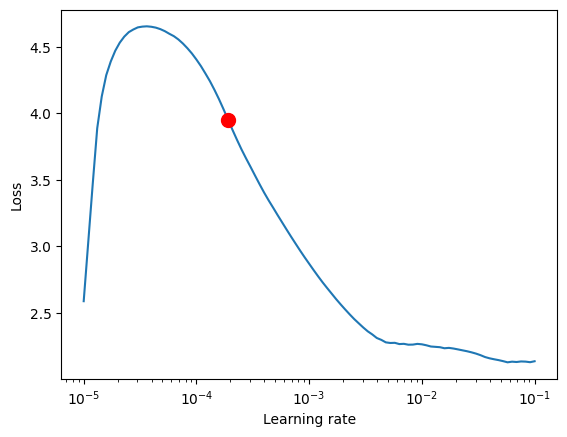

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.7 M  | train
-------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(0.3159)

In [5]:
batch_size = 1024 * 8

train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False
)

baseline_predictions = Baseline().predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cuda"), return_y=True
)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NBeats.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.1,
    widths=[32, 512],
)

pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NBeats.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.1,
    widths=[32, 512],
)

from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e-1,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

import torch

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
trainer = pl.Trainer(
    logger=False,
    max_epochs=100,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)

net = NBeats.from_dataset(
    training,
    learning_rate=0.00019054607179632476,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
    widths=[32, 512],
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to("cpu")
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"))
(actuals - predictions).abs().mean()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


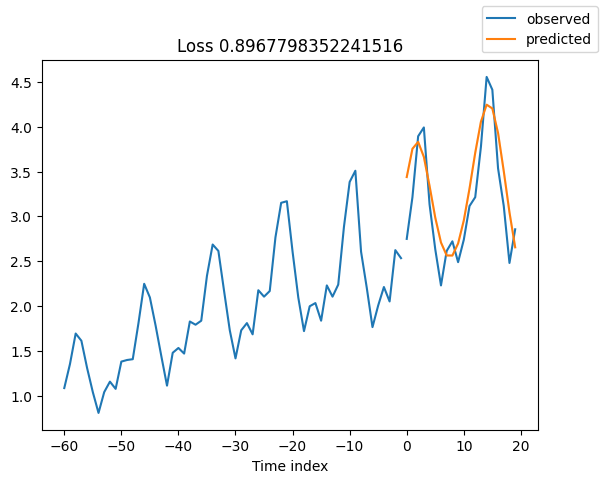

In [6]:
raw_predictions = best_model.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
for idx in range(1):
    best_model.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

### Example without precomputed tensors

Here we just use the TimeSeriesDataSet as usual

In [7]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    # Just nothing here, this will default to old algorithm
)

# validation data will also inherit precompute=True

validation = TimeSeriesDataSet.from_dataset(
    training, data, min_prediction_idx=training_cutoff + 1
)

Using precompute = False
Using precompute = False


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00019054607179632476
Restoring states from the checkpoint path at /root/work/git_proof/pytorch_forecasting/.lr_find_4b0c2dd5-d0d6-4661-b00b-853041c380d0.ckpt
Restored all states from the checkpoint at /root/work/git_proof/pytorch_forecasting/.lr_find_4b0c2dd5-d0d6-4661-b00b-853041c380d0.ckpt


suggested learning rate: 0.00019054607179632476


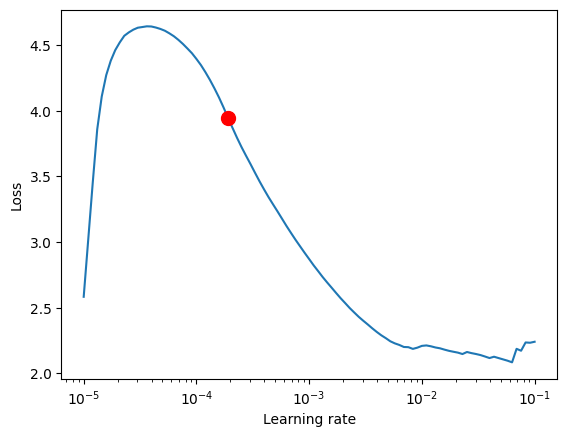

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.7 M  | train
-------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(0.3164)

In [8]:
batch_size = 1024 * 8

train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False
)

baseline_predictions = Baseline().predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cuda"), return_y=True
)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NBeats.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.1,
    widths=[32, 512],
)

pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NBeats.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.1,
    widths=[32, 512],
)

from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e-1,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

import torch

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
trainer = pl.Trainer(
    logger=False,
    max_epochs=100,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)

net = NBeats.from_dataset(
    training,
    learning_rate=0.00019054607179632476,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
    widths=[32, 512],
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to("cpu")
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"))
(actuals - predictions).abs().mean()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


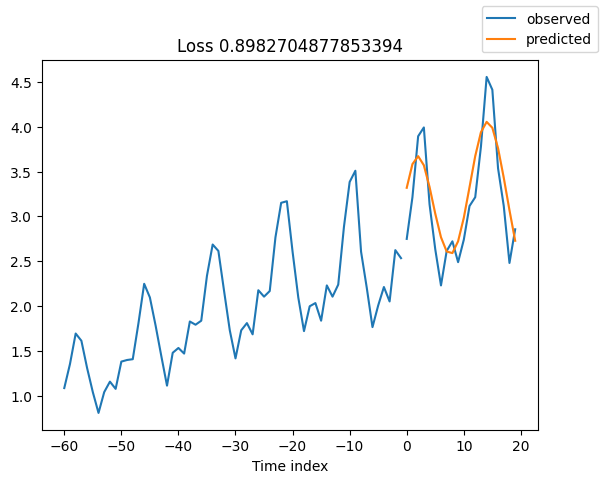

In [9]:
raw_predictions = best_model.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
for idx in range(1):
    best_model.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

### Summary

If you notice, the forecasting is almost identical between precompute=True and the old code. With a percent difference in loss of only about 0.2% in favor of the old code